In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
from model.VAE_update import *
from blackbox_pgd_model.wideresnet_update import *
from pgd_attack import *
import torch.optim as optim
import numpy as np
from util import *
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 VAE Training')
# parser.add_argument('--batch-size', type=int, default=200, metavar='N',
#                     help='input batch size for training (default: 128)')
# parser.add_argument('--test-batch-size', type=int, default=200, metavar='N',
#                     help='input batch size for testing (default: 128)')
# parser.add_argument('--x-dim', type=int, default=784)
# parser.add_argument('--hidden-dim', type=int, default=400)
# parser.add_argument('--latent-dim', type=int, default=200)
# parser.add_argument('--epochs', type=int, default=30)
# args = parser.parse_args()
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

transform_test = transforms.Compose([
    transforms.ToTensor(),
])
batch_size = 200
test_batch_size = 200
beta = 0.5
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform_test)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, **kwargs)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, **kwargs)


/home/hao/anaconda3/envs/test/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def test(vae_model, c_model, channel):
    err_num = 0
    err_adv = 0
    err_nat = 0
    c_model.eval()
    vae_model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data = Variable(data.data, requires_grad=True)
        _,_,_,x_ = vae_model(data)
        logit = c_model(x_.view(-1,channel,7,7))
        err_nat += (logit.data.max(1)[1]!=target.data).float().sum()
        # logit_new = testtime_update_mnist_new(vae_model, c_model, data, target,learning_rate=0.05, num=50, mode = 'sum', channel=channel)
        logit_new = testtime_update_mnist_new_opt(vae_model, c_model, data, target,learning_rate=0.1, num=1, mode = 'mean', channel=channel,opti='adam')
        label = logit_calculate(logit, logit_new).to(device)
        err_num += (label.data != target.data).float().sum()

        x_adv = pgd_mnist_new(vae_model, c_model, data, target, 40, 0.3, 0.01,channel)
        _,_,_,x_ = vae_model(x_adv)
        logit_adv = c_model(x_.view(-1,channel,7,7))
        # logit_adv_new = testtime_update_mnist_new(vae_model, c_model, x_adv, target,learning_rate=0.05, num=50, mode = 'sum', channel=channel)
        logit_adv_new = testtime_update_mnist_new_opt(vae_model, c_model, x_adv, target,learning_rate=0.1, num=1, mode = 'mean', channel=channel,opti='adam')
        label_adv = logit_calculate(logit_adv, logit_adv_new).to(device)
        # logit_adv = diff_update_mnist(vae_model,c_model, x_adv,target,learning_rate=0.05, num=10, mode = 'sum')
        err_adv += (label_adv.data != target.data).float().sum()
        return logit, logit_adv, logit_new, logit_adv_new, target
        # err_adv += (logit_adv.data.max(1)[1] != target.data).float().sum()
    print(len(test_loader.dataset))
    print(err_nat)
    print(err_num)
    print(err_adv)

In [5]:
channel = [16,32,64]
vae_model = VAE(zDim=4, channel=channel).to(device)
c_model = classifier(input_dim=channel[2]).to(device)
vae_model_path = './model-checkpoint/mnist-new-vae-model-65.pt'
c_model_path = './model-checkpoint/mnist-new-c-model-65.pt'
vae_model.load_state_dict(torch.load(vae_model_path))
c_model.load_state_dict(torch.load(c_model_path))


<All keys matched successfully>

In [20]:
logit, logit_adv,logit_nat_new, logit_adv_new, target = test(vae_model, c_model, channel=channel[2])

In [22]:
# label = logit_calculate(logit_adv, logit_adv_new)
label = logit_calculate(logit, logit_nat_new)
label = label.to(device)
print((logit.data.max(1)[1]!=target).sum())
print((label!=target).sum())
print([i for i in range(200) if label[i]!=target[i]])

tensor(1, device='cuda:0')
tensor(39, device='cuda:0')
[0, 2, 4, 6, 12, 15, 16, 18, 29, 31, 36, 41, 42, 43, 46, 48, 58, 62, 63, 66, 95, 96, 99, 104, 110, 115, 116, 121, 122, 139, 143, 160, 163, 174, 176, 185, 187, 191, 193]


In [10]:
idx = 8
print(target[idx])
print(logit[idx])
print(logit_nat_new[idx])

tensor(5, device='cuda:0')
tensor([-7.0811, -7.0766, -8.2404, -4.7262, -3.2518, 10.0910, -0.1785, -5.1353,
         0.1643, -4.1483], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-6.5561, -6.5970, -7.2191, -4.8665, -3.1759,  8.9692,  1.6813, -5.4885,
        -0.3468, -5.0865], device='cuda:0', grad_fn=<SelectBackward0>)


In [9]:
print(logit_adv[idx])
print(logit_adv_new[idx])

tensor([ -7.0913,  -7.9393,  -7.3403, -11.3015,  17.4487,  -8.1942,  -5.2909,
         -7.0107,  -3.2729,  -0.6414], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-5.6983, -7.2891, -5.4399, -9.7873, 14.0137, -7.1838, -5.6737, -7.1145,
        -0.8592, -0.1237], device='cuda:0', grad_fn=<SelectBackward0>)


In [9]:
# logit_diff = F.softmax(logit_nat_new) - F.softmax(logit)
# logit_diff = logit_nat_new - logit
logit_diff = logit_adv_new - logit_adv
temp1=[]
temp2=[]
label = logit_adv.data.max(1)[1]
for i in range(200):
    # temp.append(round(logit_diff[i][logit.data.max(1)[1][i].item()].item() / logit[i][logit.data.max(1)[1][i].item()].item() * 100, 2))
    temp1.append(round(logit_diff[i][label[i].item()].item(), 2))
# print([i for i in range(200) if temp[i] < -0.1])
temp = torch.abs(torch.Tensor(temp1)).to(device)
# print(logit_diff.max(1)[0]/temp)
# print(logit_diff.max(1)[0])
print(temp1)

[-0.22, -2.08, -1.65, -0.24, -2.17, -0.61, -0.47, -1.48, 1.65, -1.56, -3.95, 3.16, -0.53, 0.13, -2.63, -0.48, -1.72, -0.77, 1.54, -3.66, -1.95, -0.53, -0.61, -2.28, -3.02, 0.75, -1.24, 2.25, 0.58, -3.84, 1.88, -1.41, 0.38, -1.87, -0.96, -2.63, -0.41, -3.11, -3.45, -1.41, -2.02, -1.98, -1.06, -2.19, 1.95, 1.02, -1.64, 2.23, 0.17, -2.61, -1.41, -0.34, -2.34, 2.29, 2.65, -0.58, -2.61, -1.18, -0.7, -1.8, -0.18, -0.77, -2.27, 1.72, -0.94, -1.1, -0.29, -2.66, 2.02, 1.3, -0.54, -2.63, -0.44, 0.8, -2.44, -0.82, -0.44, 1.8, -0.91, 0.76, -0.23, -1.9, -1.63, 1.73, -1.04, 2.29, -0.67, 0.04, -1.46, -1.49, 1.08, -1.08, -1.06, 0.6, -1.98, 1.92, -1.66, -0.94, -1.23, -0.37, 2.91, 0.22, -0.95, -3.63, 0.01, -0.91, -1.96, 1.26, -0.25, 1.6, -1.0, -0.81, -1.31, -0.9, -0.57, -1.82, -4.15, -3.41, -0.48, 1.85, -0.14, 1.6, -0.6, -0.84, -0.85, -1.36, -1.1, 1.81, 0.53, -1.76, -0.43, -0.24, 0.8, -1.11, -1.97, -2.7, -1.31, -1.28, 0.43, -1.51, -1.34, -1.14, 0.11, -2.19, -0.69, -1.71, -1.57, 2.81, -0.87, -1.52, -0.35

In [4]:
def testtime_update_mnist_new_temp(vae_model, c_model, x_adv, target, learning_rate=0.1, num = 30, mode = 'mean', channel=120, opti = 'adam'):
    x_adv = x_adv.detach()
    x_hat_adv, _, _, x_ = vae_model(x_adv)
    x_copy = x_.detach().clone()
    if opti == 'adam':
        opt = optim.Adam([x_copy], lr=learning_rate)
    elif opti == 'sgd':
        opt = optim.SGD([x_copy], lr=learning_rate, momentum=0.9)
    for _ in range(num):
        if (x_hat_adv != x_hat_adv).sum() > 0:
            print('nan Error')
            exit()
        if mode == 'mean':
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, size_average=False, reduction='mean')
        else:
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, reduction='sum')
        x_.retain_grad()
        loss.backward(retain_graph=True)
        grad = torch.autograd.grad(loss, x_)
        with torch.no_grad():
            # x_.data -= learning_rate * x_.grad.data
            x_copy.grad = grad[0]
        x_.grad.data.zero_()
        opt.step()
        x_ = x_copy.detach().clone()
        x_.requires_grad = True
        x_hat_adv = vae_model.re_forward(x_)
    logit_adv = c_model(x_.view(-1,channel,7,7))
    return x_hat_adv

In [6]:
import matplotlib.pyplot as plt
def show_image(x, idx):
    x = x.view(test_batch_size,1, 28, 28)
    # x = x.detach().cpu().numpy()
    # x = x.transpose(0,2,3,1).astype("uint8")
    fig = plt.figure()
    plt.imshow(transforms.ToPILImage()(x[idx]))

In [8]:
for data, target in test_loader:
    x = data.to(device)
    target = target.to(device)
    x_hat,_,_,_ = vae_model(x)

    break

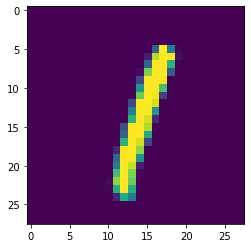

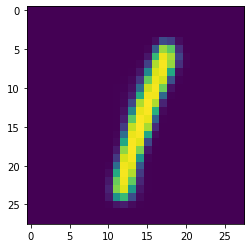

In [12]:
idx=5
show_image(x,idx)
show_image(x_hat,idx)


In [14]:
x_adv_,_,_,_ = vae_model(x_adv)
for _ in range(1):
    x_adv_,_,_,_ = vae_model(x_adv_)

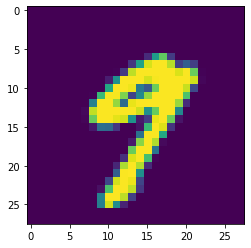

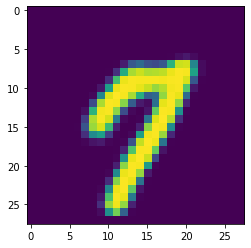

In [15]:
show_image(x,idx)
show_image(x_adv_,idx)

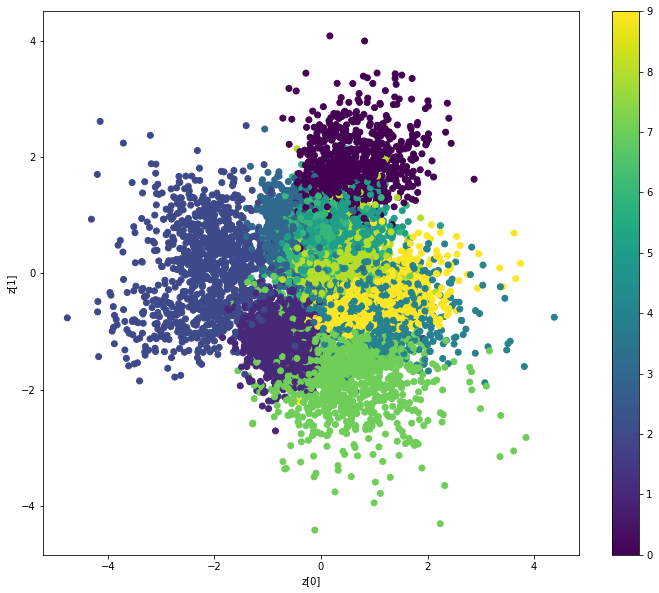

In [10]:
import matplotlib.pyplot as plt
# display a 2D plot of the digit classes in the latent space
def plot_label_clusters(VAE, train_loader):
    plt.figure(figsize=(12, 10))
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        z_mean, _,_ = VAE.encoder(data)
        plt.scatter(z_mean.cpu().detach().numpy()[:, 0], z_mean.cpu().detach().numpy()[:, 1], c=labels.cpu().detach().numpy())
        
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.colorbar()
    plt.show()


plot_label_clusters(vae_model, test_loader)